In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
import glob
import os
import peakutils
import datetime
import warnings
import logging
from jupyterthemes import jtplot

In [7]:
from xps.xps_sw import *
from xps.xps_import import *
from xps.xps_analysis import *
from xps.xps_bg import *

jtplot.style('default', grid=False)
logging.getLogger().setLevel(logging.CRITICAL)

plt.rcParams['errorbar.capsize'] = 8
plt.rcParams['font.size'] = 18
plt.rc('font', size= 18)
plt.rc('legend', fontsize= 15)
plt.rc('xtick', labelsize= 18)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', size=6)

plt.rc('ytick', labelsize= 18)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)

In [3]:
asf = dict({'C_1s' : 0.296, 'O_1s' : 0.711, 'N_1s' : 0.477, 'Ba_3d' : 7.49,
            'Cu_2p' : 5.321, 'Cl_2p' : 0.891})

In [4]:
def plot_regions(experiments : list, regions : list, colors : list = None):
    """Subplots all regions of a list of experiments (unnormalised)"""
    rows = int(np.ceil(len(regions) / 3))
    cols = 3
    
    fig, ax = plt.subplots(rows, cols, figsize=(16, 8))
    for i,r in enumerate(regions):
        for c,xp in enumerate(experiments):
            j, k = i//3, i%3            
            if i == len(regions) - 1:   # Set labels from last region
                li = plot_region(xp, r, ax=ax[j][k], lb=xp.name)
                if len(colors) > 0: li.set_color(colors[c])
                ax[j][k].set_title('Au_4f')
                ax[j][k].get_legend().remove()
            else:
                li = plot_region(xp, r, ax=ax[j][k], lb='__nolabel__')
                if len(colors) > 0: li.set_color(colors[c])
                ax[j][k].set_title(r)
            cosmetics_plot(ax=ax[j][k], leg = False);
        if len(experiments)%2 == 0:
            ax[j][k].invert_xaxis()
    plt.tight_layout()
    fig.legend()

### Background subtraction class (dev) 

In [5]:
class Background2(object):
    @staticmethod
    def bg_handler(xp, region,  *args, **kwargs):
        x = xp.dfx[region].dropna().energy.values
        y = xp.dfx[region].dropna().counts.values
        return x, y

    @staticmethod
    def edit_xp(xp, region, x, y, ybg, ax = None):
        if ax == None: ax = plt.gca()
        col = plot_region(xp, region, lb=region, ax=ax).get_color()
        ax.plot(x, ybg, '--', color=col, label='__nolabel__')
        cosmetics_plot(ax=ax)
        
        dfnew = pd.DataFrame({'energy' : x, 'counts' : y - ybg})
        xpNew = deepcopy(xp)
        xpNew.dfx[region] = dfnew
        return xpNew

    def dec_linear(self, xp, region, *args, **kwargs):
        x, y = self.bg_handler(xp, region, *args, **kwargs)

        ybg = peakutils.baseline(y, deg=1)
        return self.edit_xp(xp, region, x, y, ybg)
    
    def dec_shirley(self, xp, region, maxit=40, **kwargs):
        kwargs['maxit'] = maxit
        x,y = self.bg_handler(xp, region, **kwargs)
        ybg = shirley_loop(x,y, **kwargs)
        return self.edit_xp(xp, region, x, y, ybg)
    
    def dec_2shirley(self, xp, region, xlim, maxit=40, **kwargs):
        x, y = self.bg_handler(xp, region, **kwargs)
        y1 = y[ x >= xlim ]
        x1 = x[ x >= xlim ]
        y2 = y[ x <= xlim ]
        x2 = x[ x <= xlim ]

        ybg1 = shirley_loop(x1, y1, maxit = maxit)#, flag_plot=flag_plot, ax = ax)
        ybg2 = shirley_loop(x2, y2, maxit = maxit)#, flag_plot=flag_plot, ax = ax)
        ybg = np.append(np.append(ybg1[:-1], np.average([ybg1[-1], ybg2[0]])), ybg2[1:] )
        return self.edit_xp(xp, region, x, y, ybg, **kwargs)

NameError: name 'trim_exps' is not defined

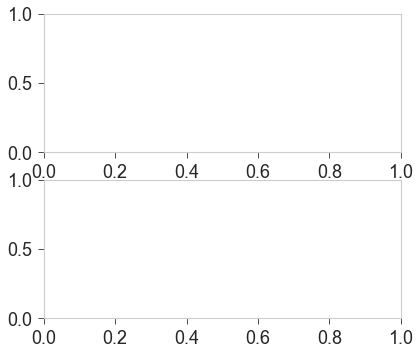

In [6]:
# Background2().dec_linear(xp=experiments[0], region='C_1s')
fig, ax = plt.subplots(2)
BG2 = Background2()
bg2 = BG2.dec_2shirley(xp=trim_exps[0], region='overview_', 
                       xlim = 346, maxit=50, ax=ax[0])
bg2 = BG2.dec_linear(xp=trim_exps[0], 
                     region='overview_', ax=ax[1])

In [ ]:
def test_bg_subpots()
    fig, ax = plt.subplots(2)
    BG2 = Background2()
    bg2 = BG2.dec_2shirley(xp=trim_exps[0], region='overview_', 
                           xlim = 346, maxit=50, ax=ax[0])
    bglin = BG2.dec_linear(xp=trim_exps[0], 
                         region='overview_', ax=ax[1])

    assert len(ax[0].get_lines()) <= 2, "Too many lines in lin_bg subplot"
    assert len(ax[0].get_lines()) >= 2, "Not enough lines in lin_bg subplot"

In [ ]:
BG2 = Background2()
bg2 = BG2.dec_2shirley(xp=trim_exps[0], region='overview_', 
                       xlim = 346, maxit=50, ax=ax[0])
x,y = BG2.bg_handler(xp=trim_exps[0], region='overview_')
x,ybg = BG2.bg_handler(bg2, region='overview_')
lentest = len(np.where(y < ybg)[0])
assert lentest == 0, "Background over signal in %i points"%lentest


In [ ]:
BG2 = Background2()
bg2 = BG2.dec_linear(xp=trim_exps[0], region='overview_')
x,y = BG2.bg_handler(xp=trim_exps[0], region='overview_')
x,ybg = BG2.bg_handler(bg2, region='overview_')
lentest = len(np.where(y < ybg)[0])
assert lentest == 0, "Background over signal in %i points"%lentest


In [ ]:
def test_method(method):
    BG2 = Background2()
    bg2 = method(xp=trim_exps[0], region='overview_')
    x,y = BG2.bg_handler(xp=trim_exps[0], region='overview_')
    x,ybg = BG2.bg_handler(bg2, region='overview_')
    lentest = len(np.where(y < ybg)[0])
    assert lentest == 0, "Background over signal in %i points"%lentest
test_method(Background2().dec_linear)

## Pre-processing of data FBI on Cu policrystal
1- Sublimations in UHV (Sept-Oct 2020)

## Import data

In [72]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/**/*.xy'
files = glob.glob(path, recursive=True)
files.sort()
files_new = []
for f in files:
    if (' ' not in f) and ('/proc' not in f):
        files_new.append(f)
# files_new.pop(2)
# files_new.pop(3)

files = files_new
for f in files:
    print(os.path.split(f)[1])

20200922_Cu_clean2.xy
20200923_Cu_FBI_subl_20min.xy
20200928_Cu_FBI_subl_20min_BaCl2_subl20mins_68W.xy
20201013_Cu_FBI_subl_20min.xy
20201013_Cu_clean2.xy
20201014_Cu_FBI_subl_25min.xy
20201014_Cu_FBI_subl_50min.xy
20201014_Cu_clean.xy
20201016_Cu_FBI_subl_5min.xy
20201016_Cu_clean.xy
20201016_Cu_clean4.xy
20201019_Cu_FBI_subl_6min.xy
20201019_Cu_clean.xy


In [11]:
find_groups(files[1])

1

In [88]:
names = ['Cu_clean', 'FBI_sublC_20min', 'FBI_BaCl_sublC_20min', 'FBI_sublB_20min', 'Cu_clean2', 
         'FBI_sublB_25min', 'FBI_sublB_50min', 'Cu_clean3', 'FBI_sublB_5min', 'Cu_clean4', 'Cu_clean5', 
         'FBI_sublB_6min', 'Cu_clean6',]
label = ['Cu clean 22 sep', 'FBI sublim ceramic crucible 20min', 'FBI BaCl sublim ceramic crucible 20min',
         'FBI sublim NiB crucible 20min', 'Cu clean 13 oct',
         'FBI sublim NiB crucible 25min', 'FBI sublim NiB crucible 50min', 'Cu clean 14 oct',
         'FBI sublim NiB crucible 5min', 'Cu clean 16 oct', 'Cu clean O 1s 16 oct',
         'FBI sublim NiB crucible 6min', 'Cu clean 19 oct']

experiments = [xps_data_import(path=f, name=n, label=l) for f,n,l in zip(files, names, label)]
experiments[1].name

'FBI_sublC_20min'

### Merge clean 4 (quick, O 1s only) 

In [89]:
experiments[9].dfx['O_1s'] = experiments[10].dfx['O_1s']
experiments[9].dfx['Cu_2p'] = experiments[10].dfx['Cu_2p']


In [90]:
from copy import deepcopy
xpInsert = deepcopy(experiments[11])
xpInsert.dfx['O_1s'] = experiments[12].dfx['O_1s']
xpInsert.dfx['N_1s'] = experiments[12].dfx['N_1s']
xpInsert.dfx['C_1s'] = experiments[12].dfx['C_1s']
xpInsert.dfx['Cu_2p'] = experiments[12].dfx['Cu_2p']
xpInsert.name = experiments[12].name
xpInsert.label = experiments[12].label

experiments[12] = xpInsert

In [93]:
experiments = experiments[:10] + experiments[11:]

### Change Ba3d5/2 to Ba 3d

In [136]:
for xp in experiments:
    try:
        xp.dfx.rename_axis({'Ba3d5/2': 'Ba_3d'}, axis=1, copy=False, inplace=True)
    except KeyError:
        pass

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  This is separate from the ipykernel package so we can avoid doing imports until


## Fix Import of peak fits stored in xy files

In [94]:
region = 'Cu_2p'

Cu_clean
FBI_sublC_20min
FBI_BaCl_sublC_20min
FBI_sublB_20min
Cu_clean2
FBI_sublB_25min
FBI_sublB_50min
Cu_clean3
FBI_sublB_5min
Cu_clean4
FBI_sublB_6min
Cu_clean6


Text(0.5, 1.0, 'Cu 2p')

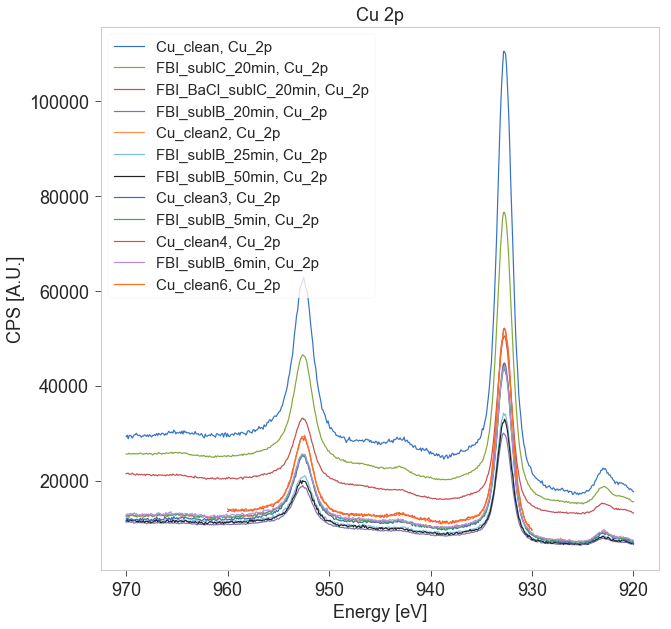

In [95]:
plt.figure(figsize=(10,10))
for xp in experiments:
    print(xp.name)
    plot_region(xp, region)
# plt.xlim(70, 100)
# plt.ylim(1.5e5, 4e5)
cosmetics_plot()
plt.title('Cu 2p')

/Users/pabloherrero/sabat/sabatsw/xps/xps_analysis.py:61: RuntimeWarning: invalid value encountered in greater
  dropup = np.where(xp.dfx[region].energy.values > eup)[0]


Text(0.5, 1.0, 'Cu 2p')

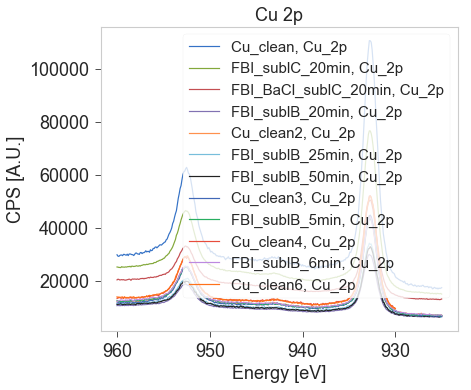

In [96]:
trim_exps = []
# for xp in experiments[:3]+experiments[4:]:
for xp in experiments:
    xp_new = crop_spectrum(xp, region=region, eup=960, edw=925)
    trim_exps.append(xp_new)
    plot_region(xp_new, region)
cosmetics_plot()
plt.title('Cu 2p')

### Subtract double shirley to all Cu regions

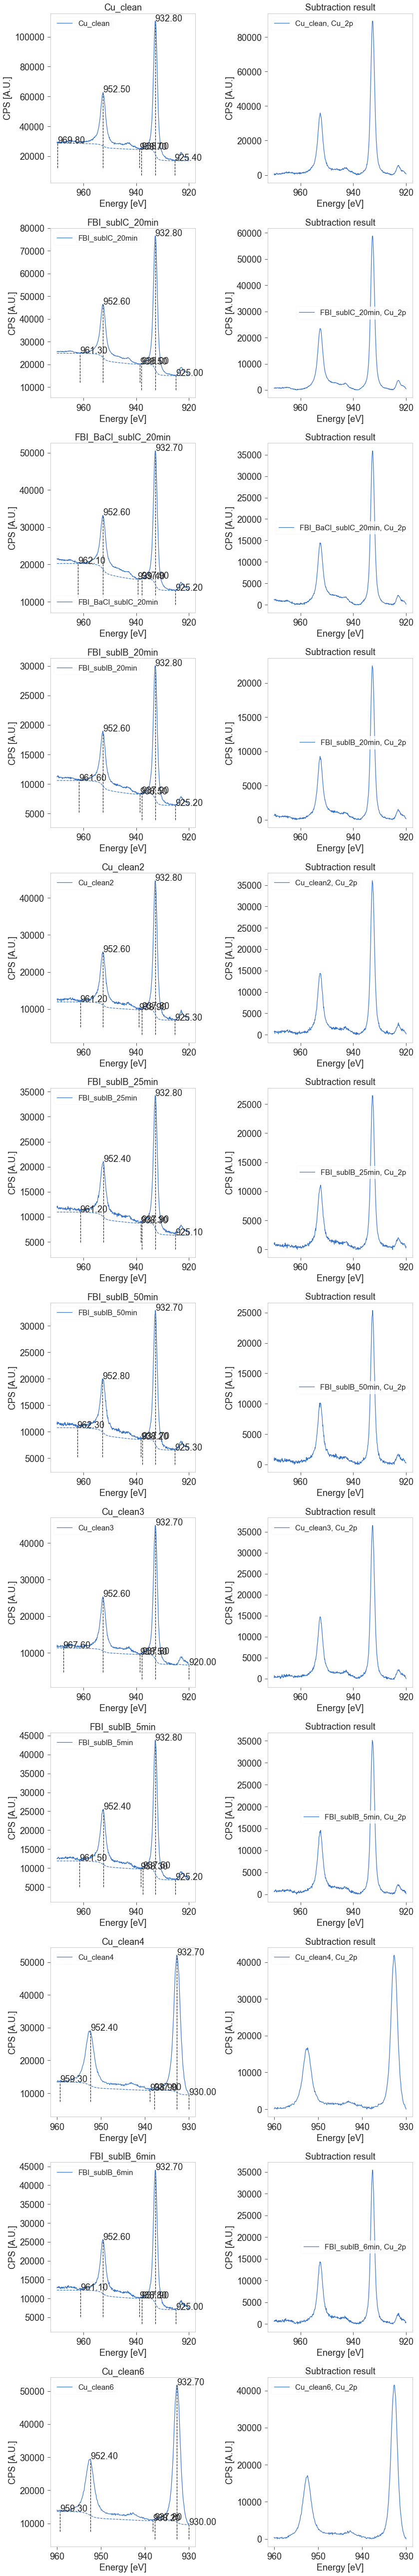

In [137]:
region = 'Cu_2p'

bg_exps = region_2bg_subtract(experiments, region=region, xlim=938)

### Bulk subtract background

Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline


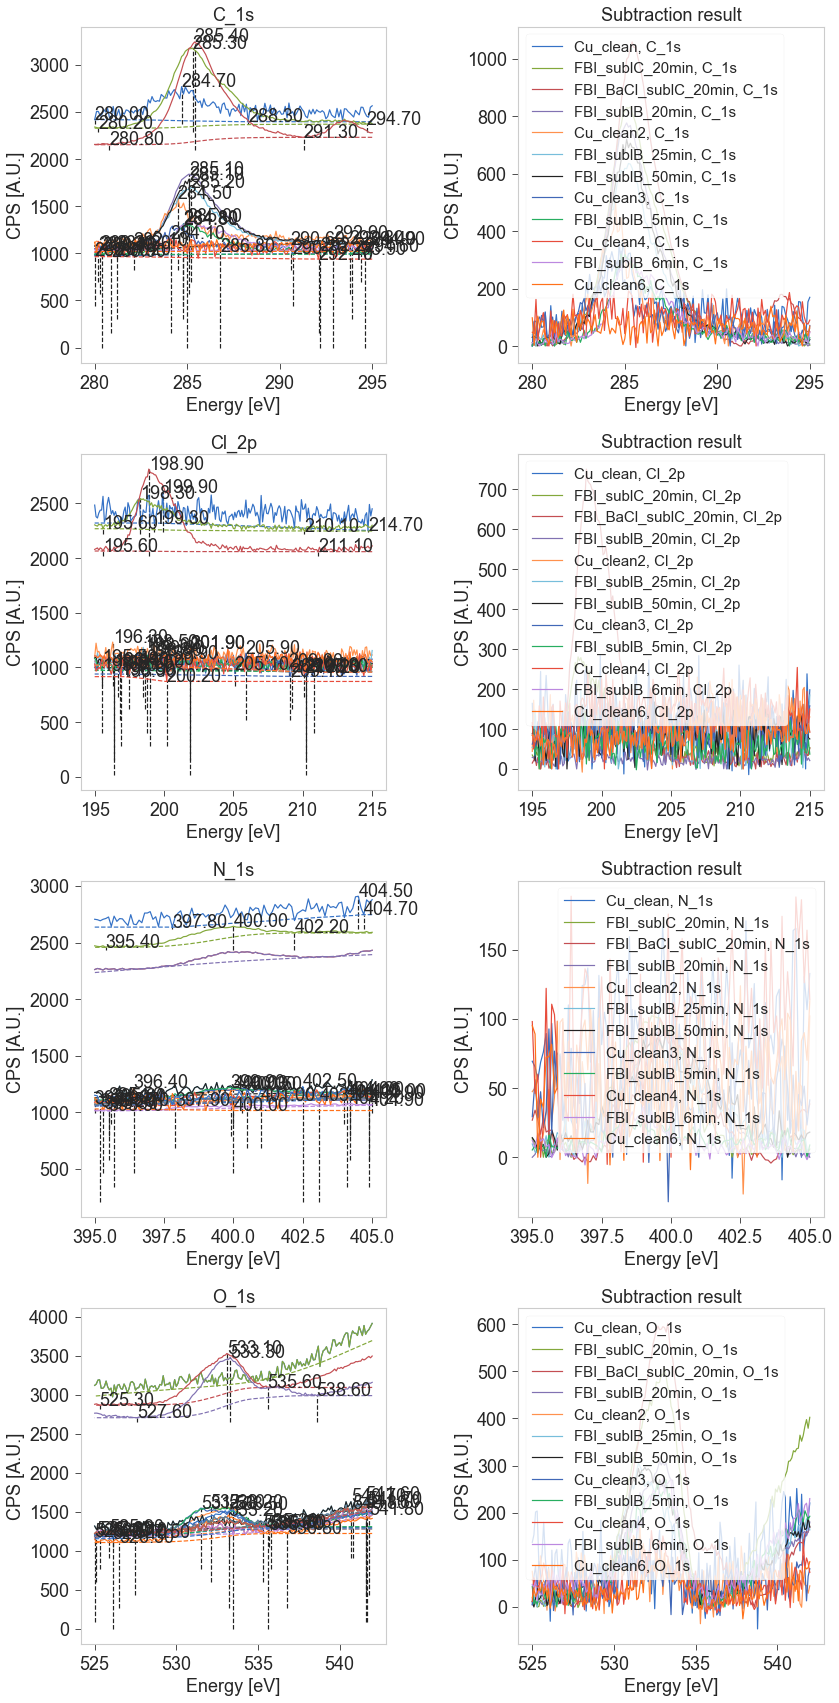

In [138]:
regions = ['C_1s', 'Cl_2p', 'N_1s', 'O_1s']
bg_exps = bulk_bg_subtract(bg_exps, regions)

#### Plot result of bulk subtract

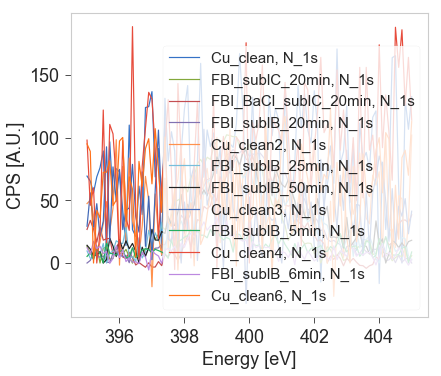

In [99]:
region = 'N_1s'
for xp in bg_exps:
    plot_region(xp, region)

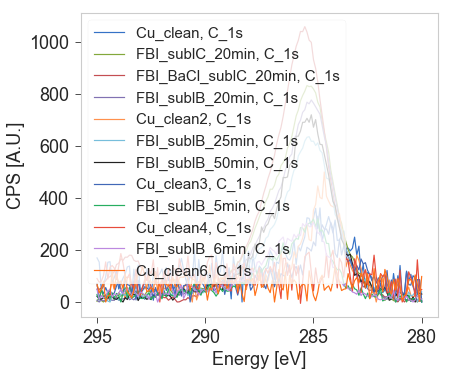

In [100]:
region = 'C_1s'
for xp in bg_exps:
    plot_region(xp, region)
cosmetics_plot()

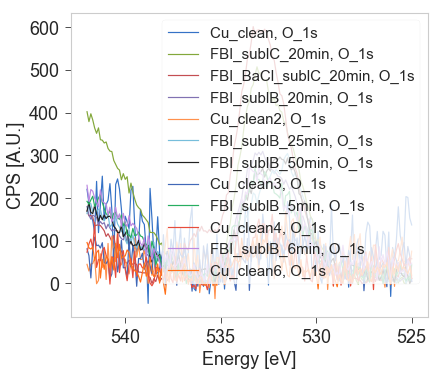

In [101]:
region = 'O_1s'
for xp in bg_exps:
    plot_region(xp, region)
cosmetics_plot()

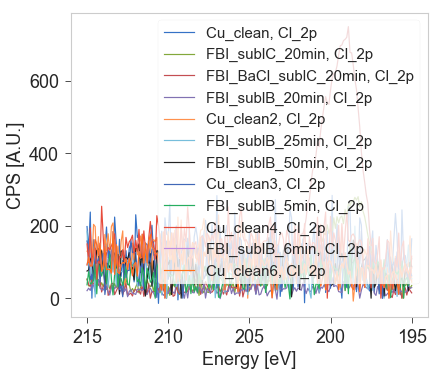

In [102]:
region = 'Cl_2p'
for xp in bg_exps:
    plot_region(xp, region)
cosmetics_plot()

### Subtract linear and shirley bg to all O 1s regions

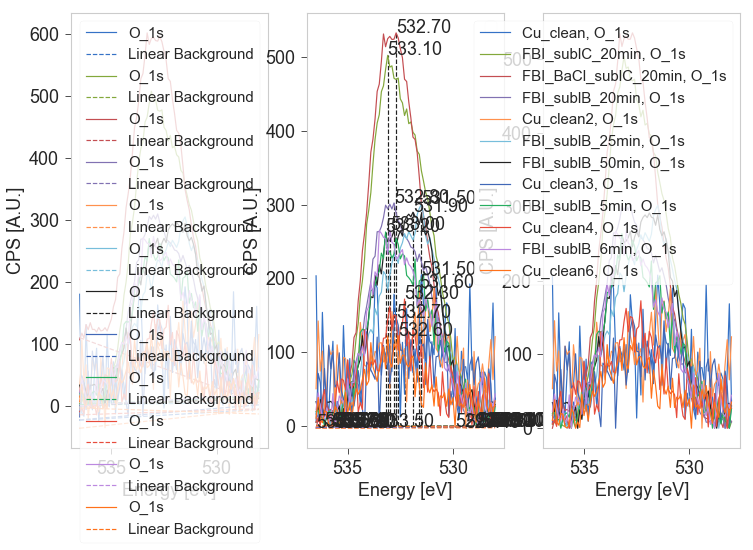

In [103]:
region = 'O_1s'
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
new_exps = []
for xp in bg_exps:
    xp_crop = crop_spectrum(xp, region, eup=536.5, edw=528)
    xp_lin = subtract_linear_bg(xp_crop, region, ax=ax[0])
    xp_bg = subtract_shirley_bg(xp_lin, region, maxit=40, ax=ax[1])
    plot_region(xp_bg, region, ax=ax[2])
    new_exps.append(xp_bg)
for i in range(3): cosmetics_plot(ax=ax[i])
# bg_exps = new_exps

### Subtract linear and shirley bg to all Ba 3d regions

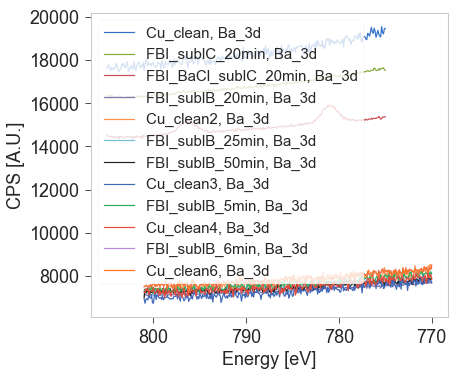

In [140]:
region = 'Ba_3d'
for xp in bg_exps:
    try:
        plot_region(xp, region)
    except KeyError: pass
cosmetics_plot()

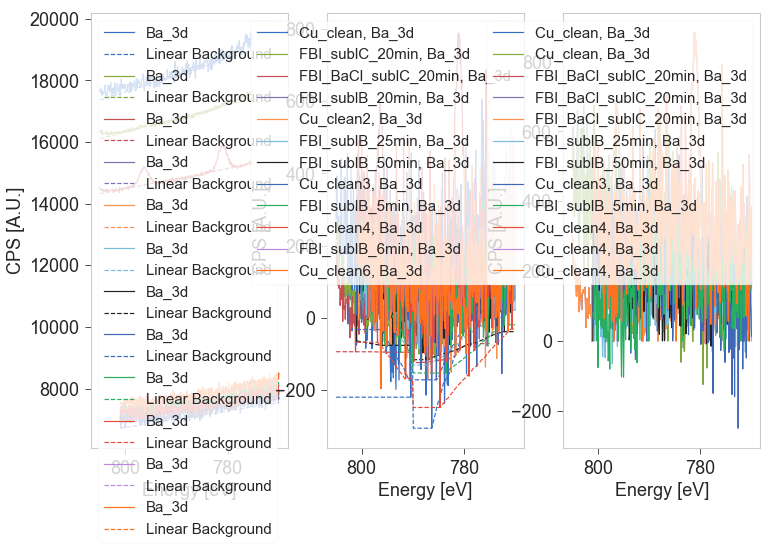

In [141]:
region = 'Ba_3d'
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
for i, xp in enumerate(bg_exps):
    try:
        xp_lin = subtract_linear_bg(xp, region, ax=ax[0])
        try: 
            xp_bg = subtract_double_shirley(xp_lin, region, xlim=790, maxit=40, ax=ax[1])
            bg_exps[i] = xp_bg
        except AssertionError: 
            bg_exps[i] = xp_lin
            pass
        plot_region(xp_bg, region, ax=ax[2])
    except KeyError: pass
for i in range(3): cosmetics_plot(ax=ax[i])
# bg_exps = new_exps

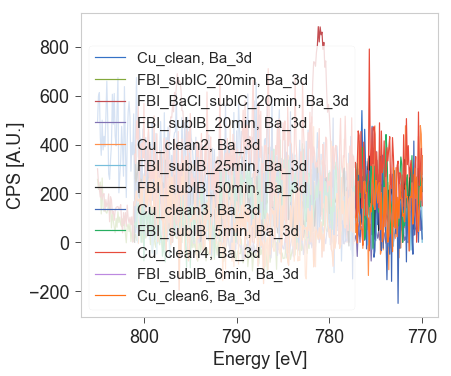

In [142]:
region = 'Ba_3d'
for xp in bg_exps:
    try:
        plot_region(xp, region)
    except KeyError: pass
cosmetics_plot()

## Compress noisy regions

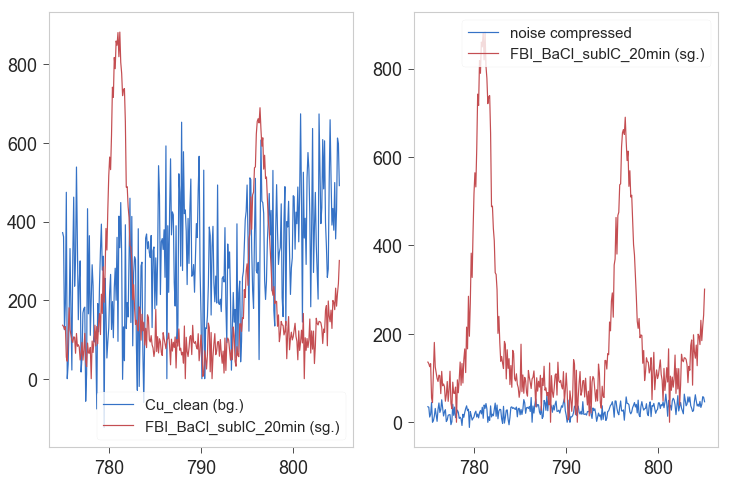

In [143]:
region= 'Ba_3d'
compress_noisy_region(bg_exps[0], bg_exps[2], region, inplace=True);

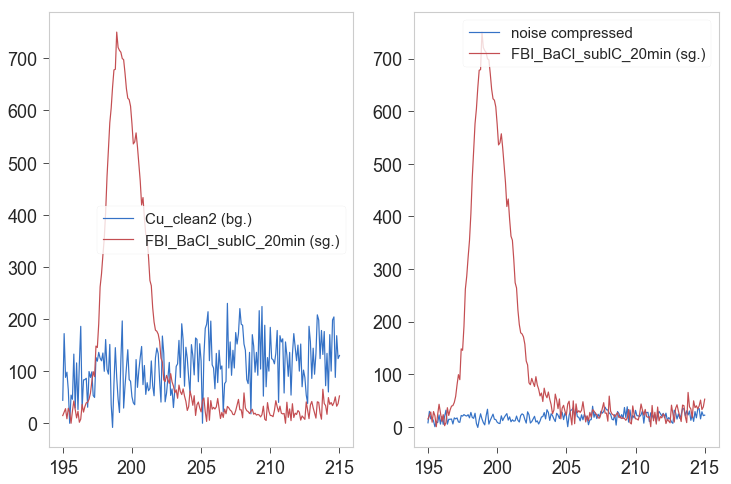

In [108]:
region= 'Cl_2p'
compress_noisy_region(bg_exps[4], bg_exps[2], region, inplace=True);

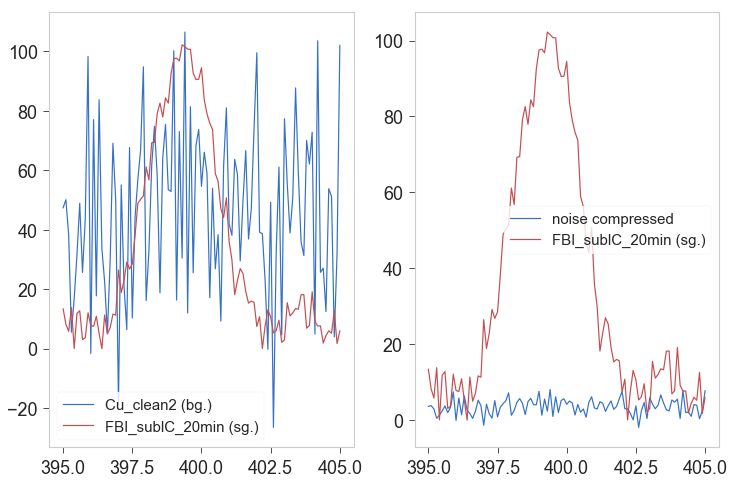

In [109]:
region= 'N_1s'
compress_noisy_region(bg_exps[4], xpRef=bg_exps[1], region=region, inplace=True);

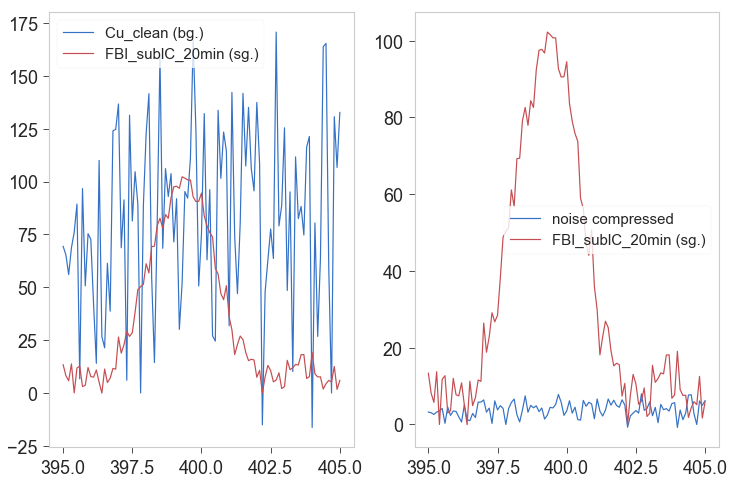

In [110]:
region= 'N_1s'
compress_noisy_region(bg_exps[0], xpRef=bg_exps[1], region=region, inplace=True);

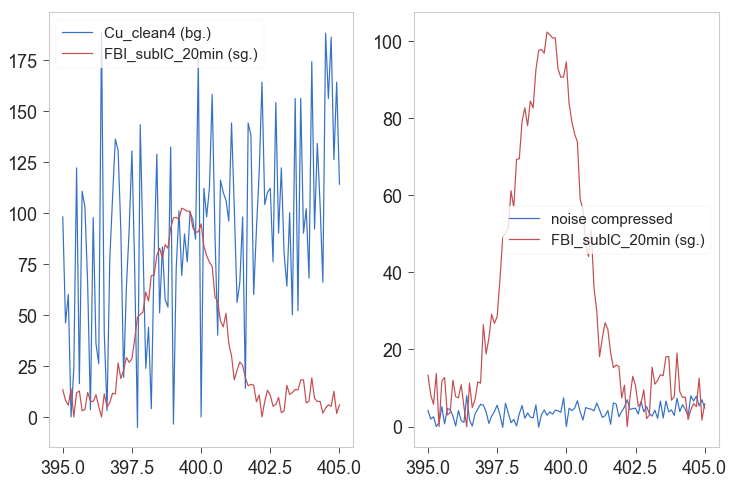

In [111]:
region= 'N_1s'
compress_noisy_region(bg_exps[9], xpRef=bg_exps[1], region=region, inplace=True);

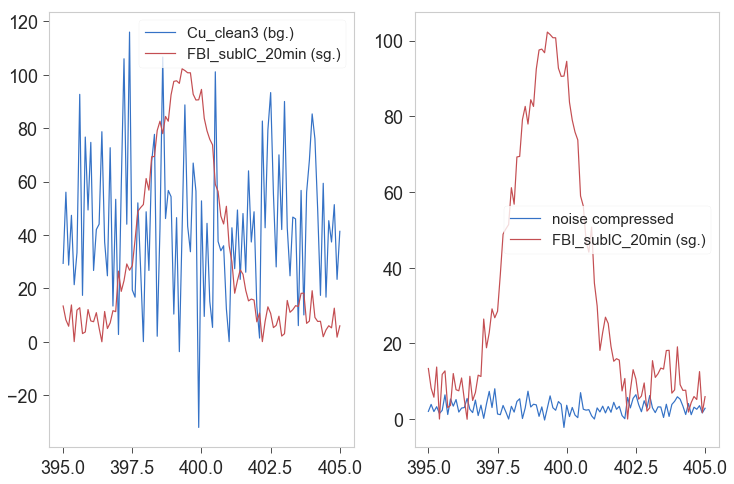

In [112]:
region= 'N_1s'
compress_noisy_region(bg_exps[7], xpRef=bg_exps[1], region=region, inplace=True);

In [84]:
bg_exps[4].dfx[region] = xp_bg.dfx[region]

In [85]:
bg_exps[4].dfx[region].max()

properties
energy    805.000000
counts    642.890574
dtype: float64

## Scale to Cu 2p

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


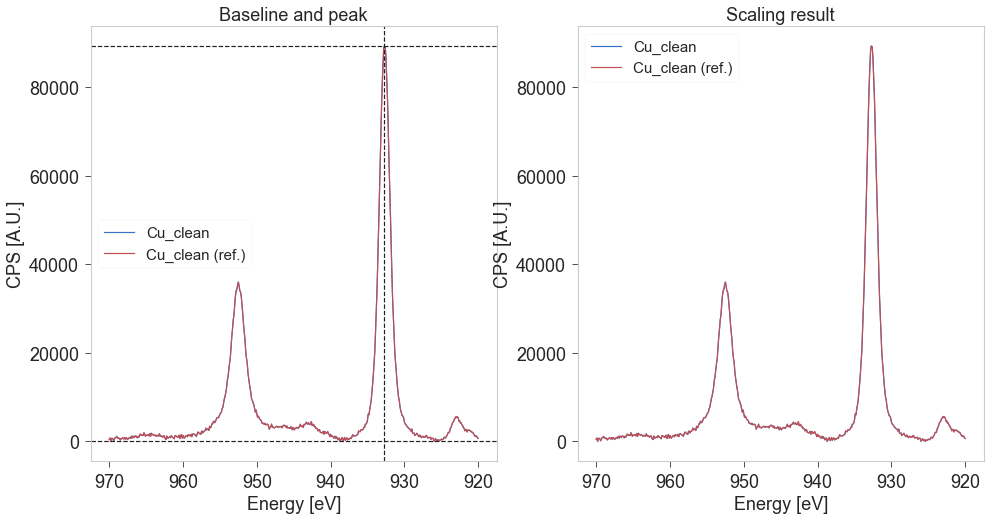

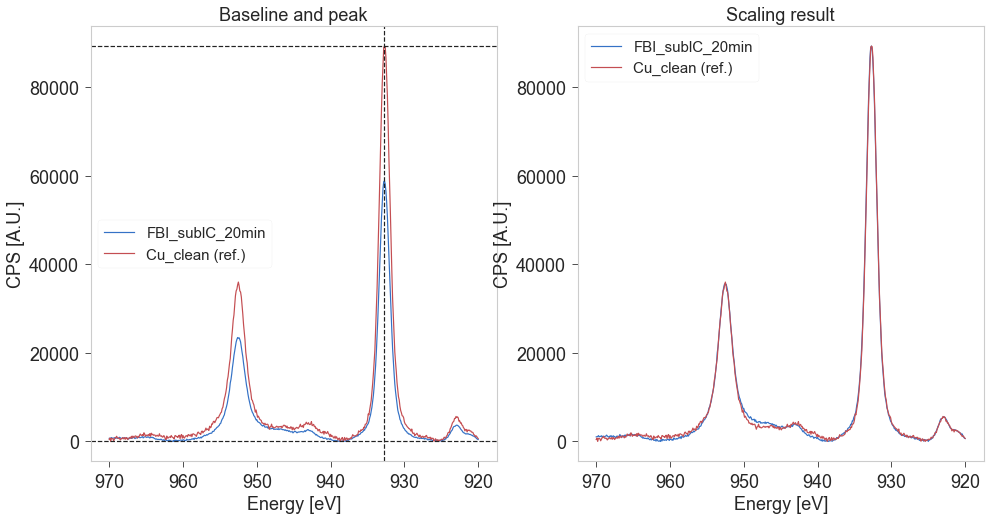

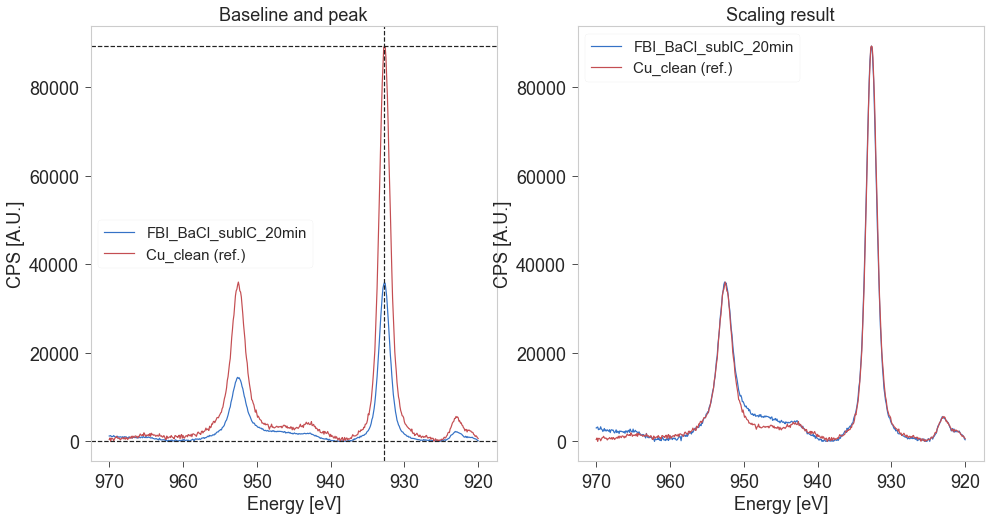

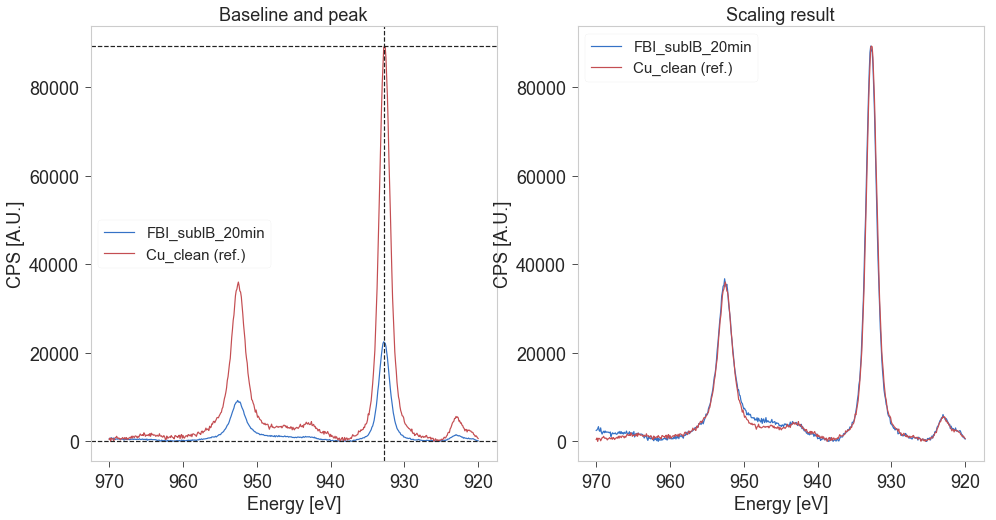

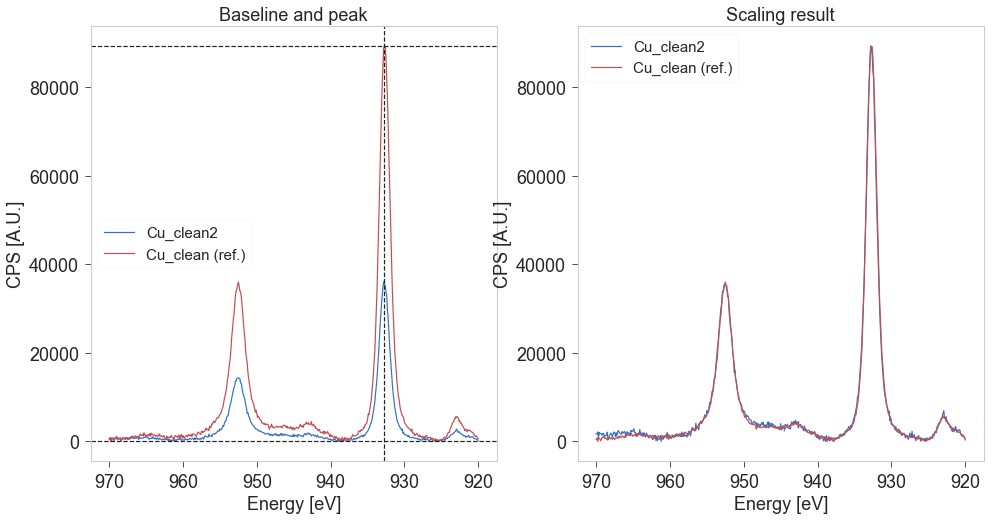

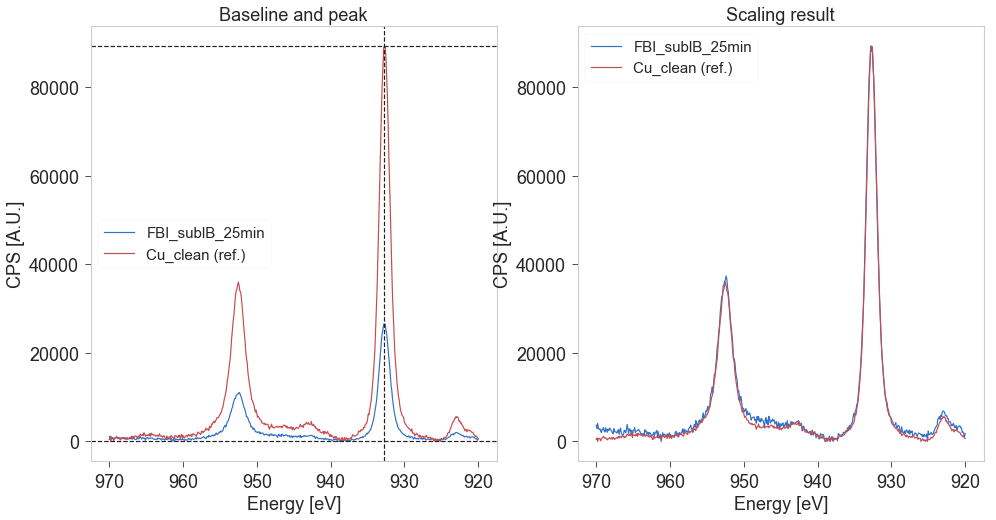

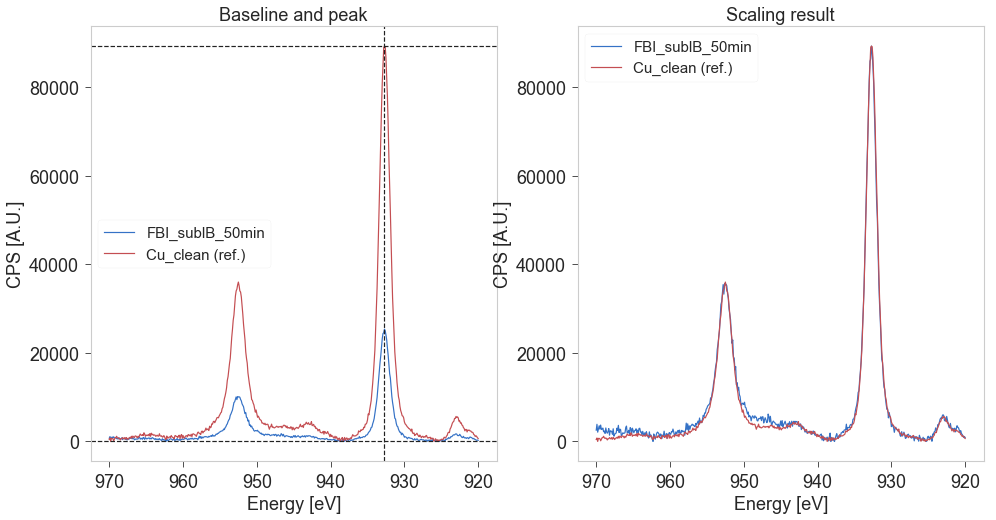

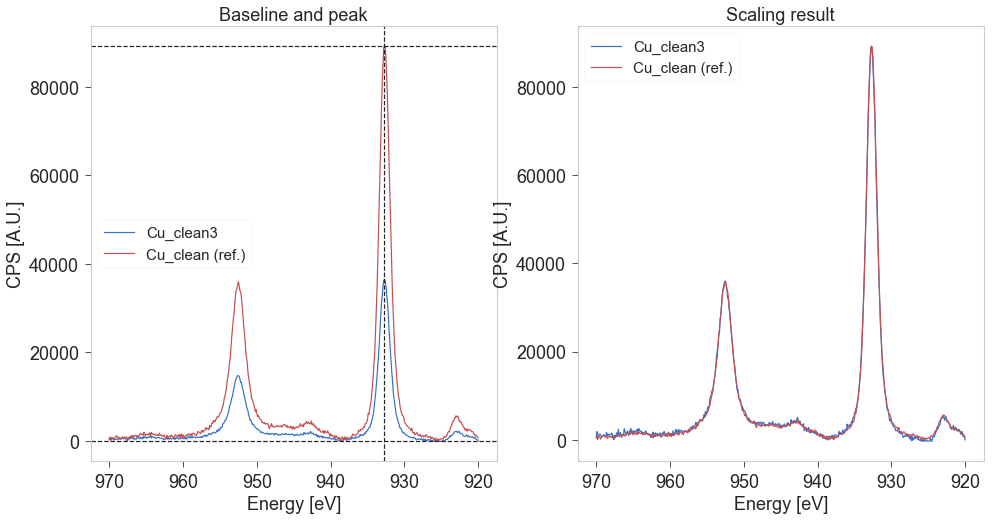

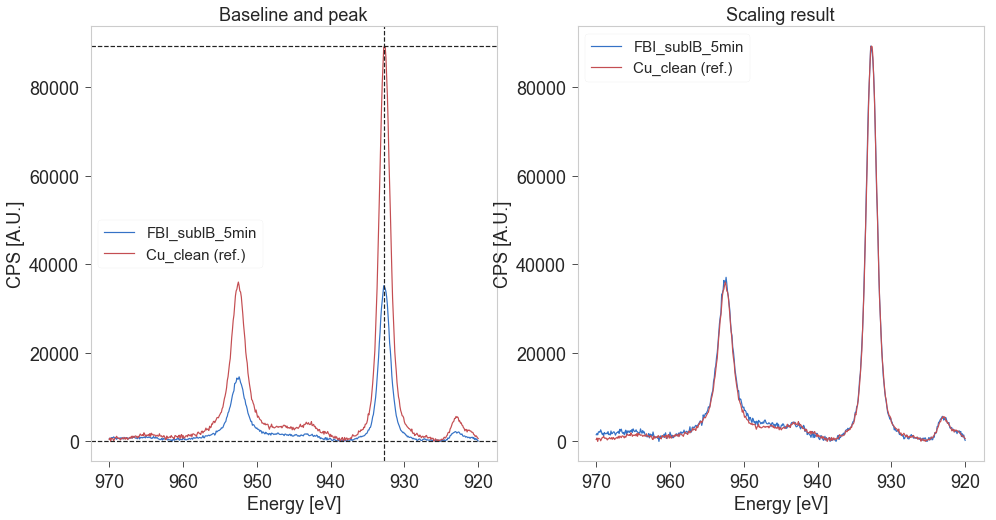

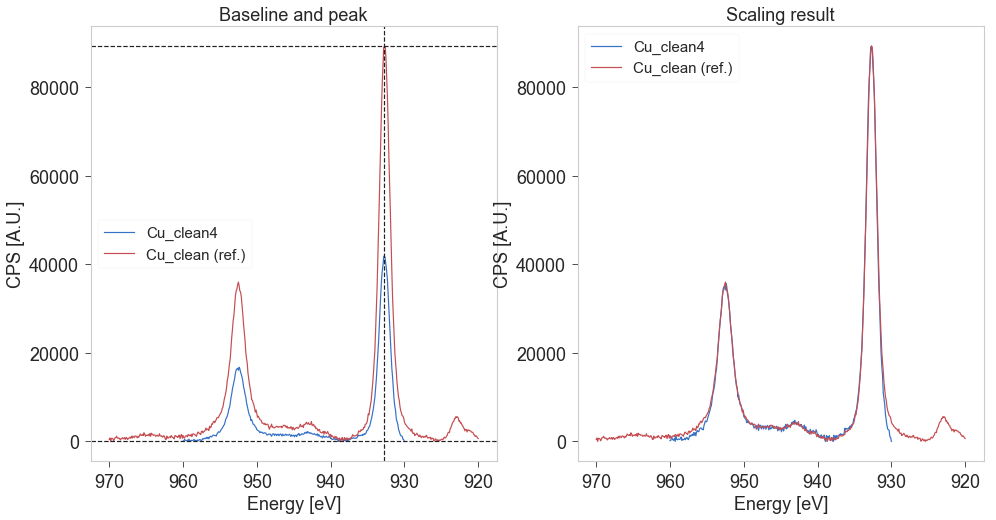

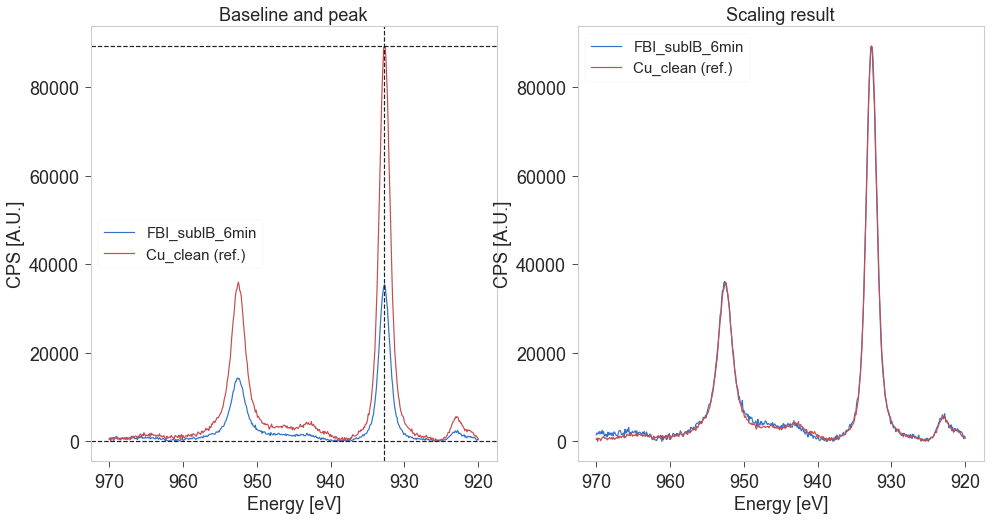

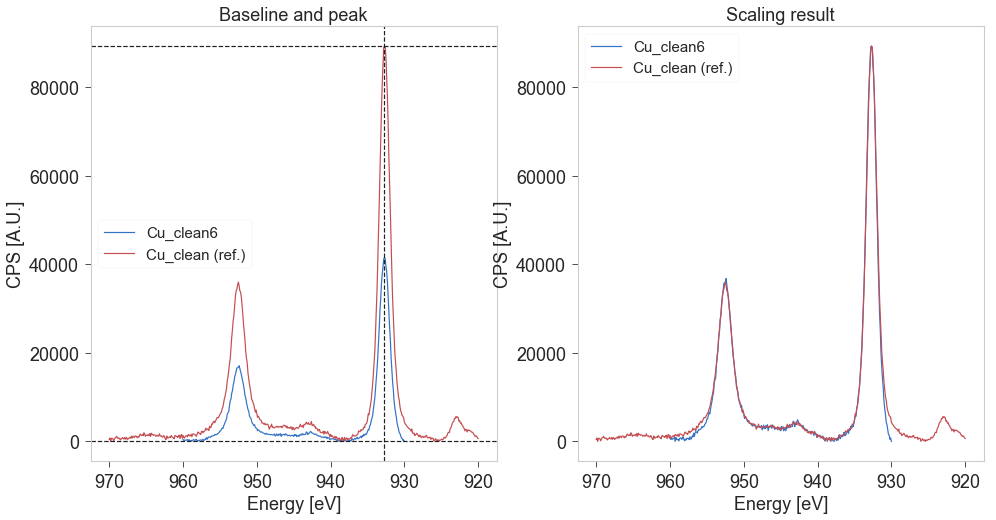

In [113]:
scaled_exps = []
for xpbg in bg_exps:
    scale = scale_and_plot_spectra(xp = xpbg, xpRef = bg_exps[0], region = 'Cu_2p')
    scaled_exps.append(scale_dfx(xp = xpbg, scale_factor = scale))

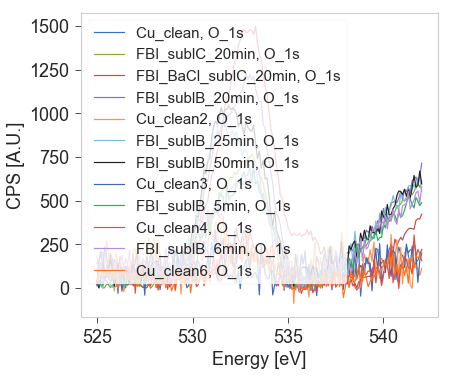

In [114]:
for xp in scaled_exps:
    plot_region(xp, 'O_1s')
# cosmetics_plot()

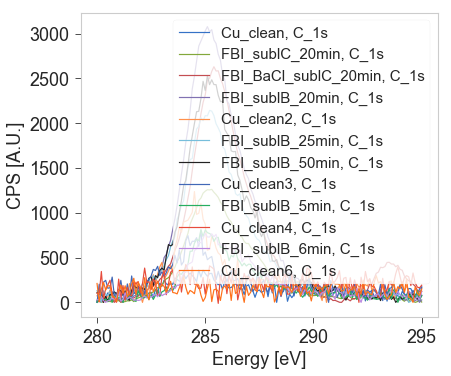

In [115]:
for xp in scaled_exps:
    plot_region(xp, 'C_1s')
# cosmetics_plot()

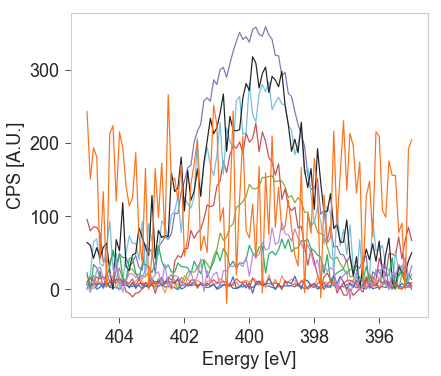

In [116]:
for xp in scaled_exps:
    plot_region(xp, 'N_1s')
cosmetics_plot()
plt.legend().remove()

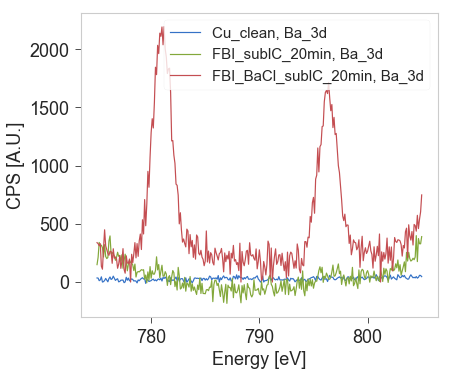

In [117]:
for xp in scaled_exps:
    try:
        plot_region(xp, 'Ba_3d')
    except KeyError: pass
cosmetics_plot()

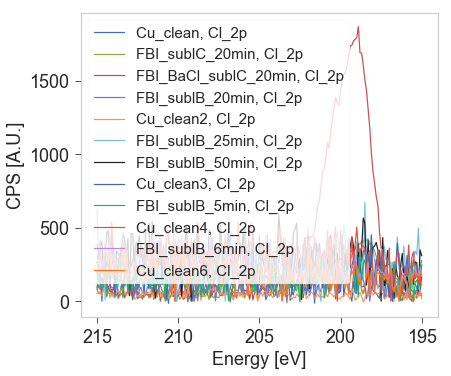

In [118]:
for xp in scaled_exps:
    plot_region(xp, 'Cl_2p')
cosmetics_plot()

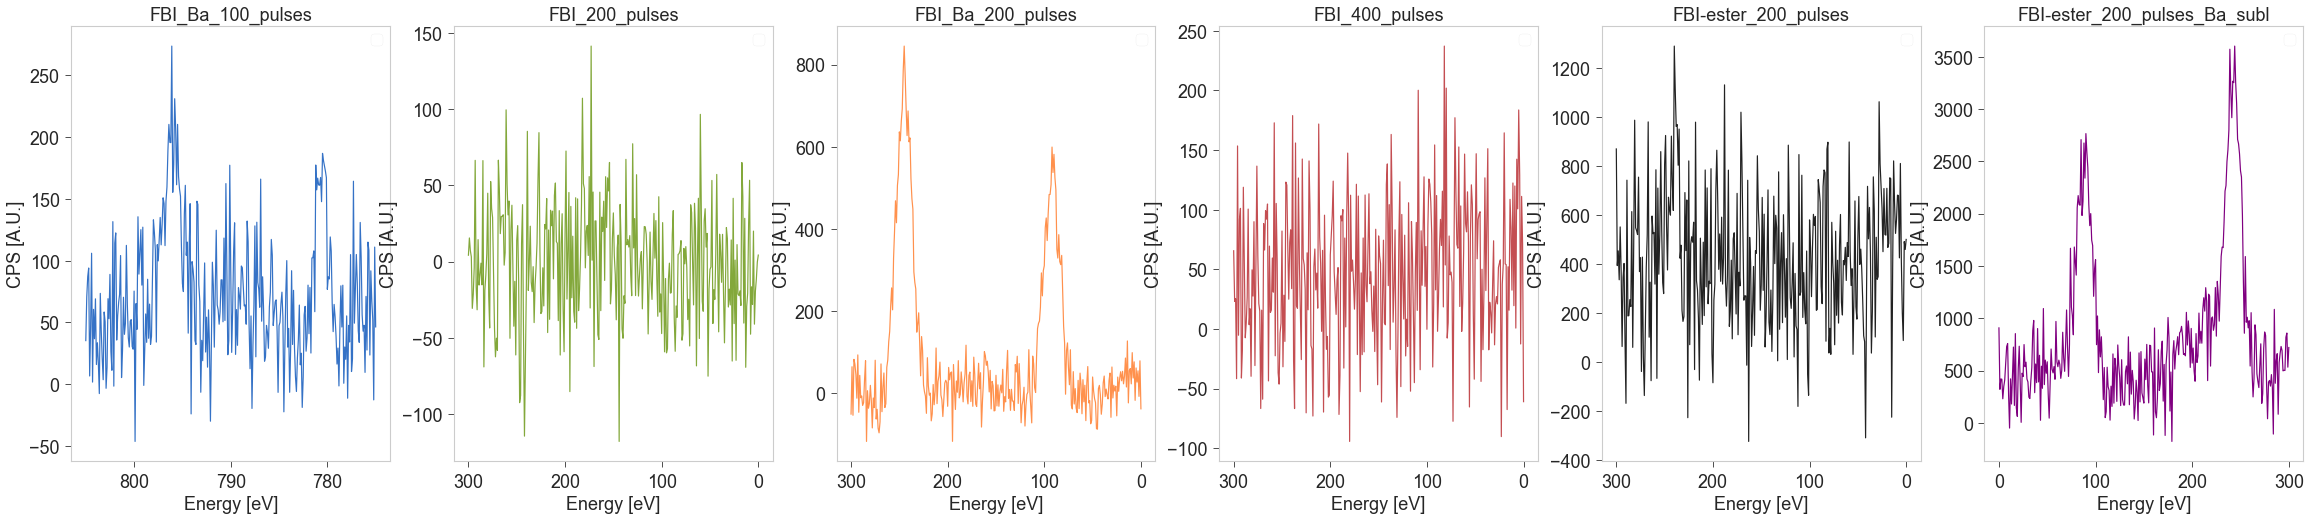

In [30]:
region = 'Ba_3d'
colors = ['b', 'g', 'y', 'r', 'k', 'purple']
fig, ax = plt.subplots(1, 6, figsize=(40, 8))
for i,xp in enumerate(scaled_exps[2:8]):
    if i == 0:   # Set labels from last region
        li = plot_region(xp, 'Ba_3d', ax=ax[i], lb='__nolabel__')
    else:
        dfsub = xp.dfx[region].counts-scaled_exps[0].dfx[region].counts
        li = ax[i].plot(dfsub, label='__nolabel__')[0]
    if len(colors) > 0: li.set_color(colors[i])
    ax[i].set_title(xp.name)
    cosmetics_plot(ax=ax[i])
# plt.tight_layout()

## Store processed experiments

In [119]:
import os
for xp, xpProc in zip(experiments, scaled_exps):
    filepath, filename = os.path.split(xp.path)
    newpath = filepath + '/proc/'
    try:
        os.mkdir(newpath)
    except FileExistsError: pass
#     print(newpath + filename)
    write_processed_xp(newpath + filename, xpProc)

## Draft: Layer thickness from Cu attenuation

$$ I_f = I_0 \exp{\left(-\frac{d_A \cos\theta}{\lambda_A} \right)}, $$

where $I_f$ and $I_0$ are the covered and clean intensities of the copper, $d_A$ is the coverage (thickness of layer A), $\theta$ is the takeoff angle and $\lambda_A$ is the mean free path of the material.

$\lambda_{Cu}$ = 39.9 nm

$\lambda_{FBI}$ = 3.85 nm

$\cos\theta = \cos$(10º) = 0.9848

In [16]:
experiments[4].dfx

range        C_1s              N_1s             Cl_2p           O_1s  \
properties energy     counts energy     counts energy  counts energy   
0           295.0  1154.6667  405.0  1288.0000  215.0  1114.0  542.0   
1           294.9  1133.3333  404.9  1217.3333  214.9  1108.0  541.9   
2           294.8  1136.6667  404.8  1188.6667  214.8  1152.0  541.8   
3           294.7  1113.3333  404.7  1235.3333  214.7  1072.0  541.7   
4           294.6  1117.3333  404.6  1237.3333  214.6  1188.0  541.6   
5           294.5  1112.6667  404.5  1195.3333  214.5  1182.0  541.5   
6           294.4  1141.3333  404.4  1209.3333  214.4  1084.0  541.4   
7           294.3  1169.3333  404.3  1207.3333  214.3  1154.0  541.3   
8           294.2  1140.6667  404.2  1284.6667  214.2  1044.0  541.2   
9           294.1  1166.0000  404.1  1185.3333  214.1  1118.0  541.1   
10          294.0  1174.0000  404.0  1252.6667  214.0  1056.0  541.0   
11          293.9  1148.0000  403.9  1241.3333  213.9  1160.0  540.9   
12          293.8  1132.6667  403.8  1248.6667  213.8  1116.0  540.8   
13          293.7  1106.6667  403.7  1209.3333  213.7  1162.0  540.7   
14          293.6  1188.6667  403.6  1213.3333  213.6  1108.0  540.6   
15          293.5  1186.6667  403.5  1236.0000  213.5  1182.0  540.5   
16          293.4  1113.3333  403.4  1264.0000  213.4  1192.0  540.4   
17          293.3  1143.3333  403.3  1226.6667  213.3  1118.0  540.3   
18          293.2  1168.6667  403.2  1214.0000  213.2  1078.0  540.2   
19          293.1  1128.6667  403.1  1230.0000  213.1  1128.0  540.1   
20          293.0  1119.3333  403.0  1251.3333  213.0  1070.0  540.0   
21          292.9  1147.3333  402.9  1178.0000  212.9  1140.0  539.9   
22          292.8  1143.3333  402.8  1234.0000  212.8  1170.0  539.8   
23          292.7  1144.6667  402.7  1204.6667  212.7  1022.0  539.7   
24          292.6  1198.0000  402.6  1145.3333  212.6  1038.0  539.6   
25          292.5  1166.0000  402.5  1220.6667  212.5  1072.0  539.5   
26          292.4  1172.6667  402.4  1170.6667  212.4  1086.0  539.4   
27          292.3  1162.6667  402.3  1193.3333  212.3  1054.0  539.3   
28          292.2  1168.6667  402.2  1208.6667  212.2  1136.0  539.2   
29          292.1  1160.6667  402.1  1208.6667  212.1  1084.0  539.1   
..            ...        ...    ...        ...    ...     ...    ...   
471           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
472           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
473           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
474           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
475           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
476           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
477           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
478           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
479           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
480           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
481           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
482           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
483           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
484           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
485           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
486           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
487           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
488           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
489           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
490           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
491           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
492           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
493           NaN        NaN    NaN     

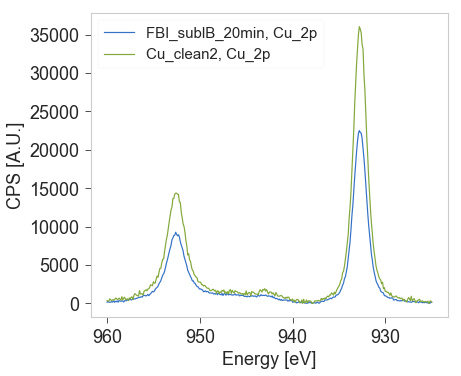

In [20]:
region = 'Cu_2p'
xpf = crop_spectrum(bg_exps[3], region, eup=960, edw=925)
xp0 = crop_spectrum(bg_exps[4], region, eup=960, edw=925)

plot_region(xpf, region)
plot_region(xp0, region)
cosmetics_plot()

In [27]:
If = np.trapz(xpf.dfx[region].dropna().counts, dx=0.1)
I0 = np.trapz(xp0.dfx[region].dropna().counts, dx=0.1)
from invisible_cities.core.system_of_units import nm
mfp = 3.85 * nm
costh = np.cos(10*np.pi/180)

thick = mfp/costh*np.log(I0/If)
thick / nm
# np.log(I0/If+1)

3.702775993853286

######  Layer of 3.7 nm

## Taking the ratio of the maxima

In [29]:
If = np.max(xpf.dfx[region].dropna().counts)
I0 = np.max(xp0.dfx[region].dropna().counts)
from invisible_cities.core.system_of_units import nm
mfp = 3.85 * nm
costh = np.cos(10*np.pi/180)

thick = mfp/costh*np.log(I0/If)
thick / nm
# np.log(I0/If+1)

1.8414430142005438